# Validations

### Common Imports

In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2

# Helper functions

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy
import torch

In [3]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


Using cache found in /Users/ldalessi/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
import torchvision
a = torchvision.models.resnet50()

In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Input data

input_data.shape --> torch.Size([200, 400])


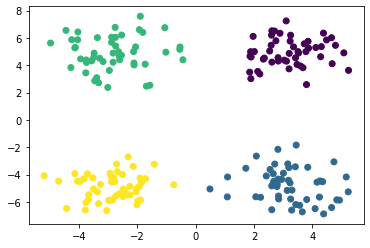

In [3]:
n, k, p = 200, 2, 400

U_true, S_true, V_true = torch.randn((n,k)), torch.randn(k).exp(), torch.randn((k,p))
color = torch.zeros(n)
color[:int(0.25*n)] = 0
color[int(0.25*n):int(0.5*n)] = 1
color[int(0.5*n):int(0.75*n)] = 2
color[int(0.75*n):] = 3

dx,dy = 3, 5
U_true[color==0] += torch.tensor([dx,dy])  
U_true[color==1] += torch.tensor([dx,-dy])  
U_true[color==2] += torch.tensor([-dx,dy])  
U_true[color==3] += torch.tensor([-dx,-dy])  
plt.scatter(U_true[:,0], U_true[:,1], c=color)

input_data = U_true @ torch.diag(S_true) @ V_true
print("input_data.shape -->",input_data.shape)

## Approximate method

In [19]:
n, p = input_data.shape
q = min(n, p)
U, S, V = torch.pca_lowrank(input_data, center=False, niter=200, q=q)
assert U.shape == torch.Size([n, q])
assert S.shape == torch.Size([q])
assert V.shape == torch.Size([p, q])
dist = torch.dist(input_data, U @ torch.diag(S) @ V.permute(1,0))
print("dist -->", dist)
eigen_approx = S.pow(2) / (n - 1)
x_approx = torch.einsum("np, pq -> nq", input_data, V)
print("x_approx.shape -->", x_approx.shape)
print("eigen_approx.shape -->", eigen_approx.shape)

dist --> tensor(0.0023)
x_approx.shape --> torch.Size([200, 200])
eigen_approx.shape --> torch.Size([200])


## Exact method via covariance

In [71]:
cov = torch.einsum('np,nq -> pq', input_data, input_data) / (n - 1)  # (p x p) covariance matrix
eps = 1E-4 * torch.randn(cov.shape[0], dtype=cov.dtype, device=cov.device)
cov += torch.diag(eps)
assert cov.shape == torch.Size([p, p])
U, S, V = torch.linalg.svd(cov, full_matrices=True)
eigen_cov = S[:min(n,p)]
U = U[:, :min(n,p)]
x_cov = torch.einsum("np, pq -> nq", input_data, U)
print("x_cov.shape -->", x_cov.shape)
print("eigen_cov.shape -->", eigen_cov.shape)

x_cov.shape --> torch.Size([200, 200])
eigen_cov.shape --> torch.Size([200])


## Scikit

In [72]:
from sklearn.decomposition import PCA

n, p = input_data.shape
q = min(n, p)

pca_scikit = PCA(n_components=q, copy=False, whiten=False,
                 svd_solver='auto', tol=0.0,
                 iterated_power='auto', random_state=0)
x_scikit = pca_scikit.fit_transform(input_data.detach().cpu().numpy())
eigen_scikit = pca_scikit.explained_variance_
print("x_scikit.shape -->", x_scikit.shape)
print("eigen_scikit.shape -->", eigen_scikit.shape)

x_scikit.shape --> (200, 200)
eigen_scikit.shape --> (200,)


# Comparison

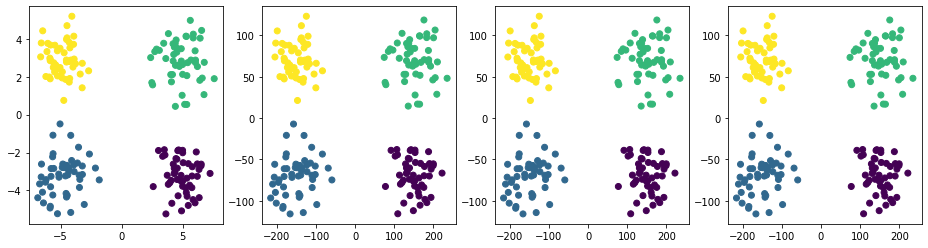

In [73]:
fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
axes[0].scatter(U_true[:,1], -U_true[:,0], c=color)
axes[1].scatter(-x_approx[:,0], x_approx[:,1], c=color)
axes[2].scatter(x_scikit[:,0], x_scikit[:,1], c=color)
axes[3].scatter(x_cov[:,0], -x_cov[:,1], c=color)

tensor([0.9950, 0.9950])
tensor([0.9950, 0.9950, 0.0039, 0.0037, 0.0109])
tensor([2.9723e-01, 2.9333e-01, 7.7697e-08, 7.4568e-08, 1.2981e-07])


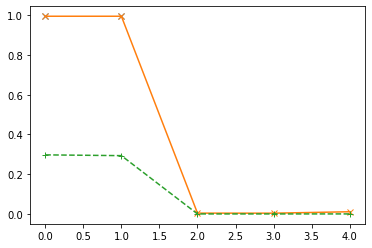

In [69]:
def corr(x,y):
    if isinstance(x, numpy.ndarray):
        x = torch.from_numpy(x)
    if isinstance(y, numpy.ndarray):
        y = torch.from_numpy(y)
    # print(x.shape, y.shape)
        
    x_std, x_mu = torch.std_mean(x, axis=-2)
    y_std, y_mu = torch.std_mean(y, axis=-2)
    cov = torch.mean((x-x_mu)*(y-y_mu), axis=-2)
    corr = cov / (x_std * y_std)
    corr_abs = numpy.abs(corr)
    print(corr_abs[:5])
    return corr_abs

U = torch.stack((U_true[:,1], U_true[:,0]), dim=-1)


plt.plot(corr(U, x_scikit[:,:2]), 'x') 
plt.plot(corr(x_scikit, x_approx)[:5], '-x') 
plt.plot(corr(x_scikit, x_cov)[:5], '--+') 

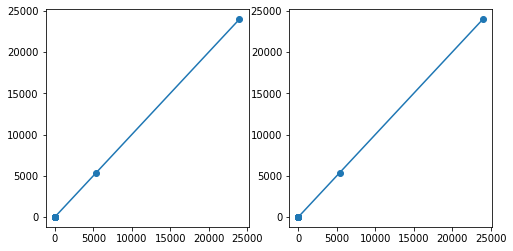

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
line = torch.linspace(0, max(eigen_scikit), 2)
axes[0].scatter(eigen_scikit.flatten(), eigen_cov)
axes[0].plot(line,line)
axes[1].scatter(eigen_scikit, eigen_approx)
axes[1].plot(line,line)